In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim
from sklearn import decomposition
from sklearn import manifold
import copy
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import time

In [24]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [25]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d(7)
    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim),
    )
  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

In [26]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

In [27]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 1
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
      else:
        layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = c
  return nn.Sequential(*layers)

In [28]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [29]:
OUTPUT_DIM = 10
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [30]:
ROOT = '.data'
pretrained_size = 224
train_data = datasets.MNIST(root = ROOT, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(pretrained_size),
                               transforms.RandomRotation(5, fill=(0,)),                                    
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_data = datasets.MNIST(root = ROOT, train=False, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(pretrained_size),                                        
                               transforms.ToTensor(),
                               transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [31]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure()
    for i in range(rows*cols):
      ax = fig.add_subplot(rows, cols, i+1)
      image = images[i]
      ax.imshow(image.view(224, 224).cpu().numpy(), cmap = 'bone')
      ax.axis('off')

In [32]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data)-n_train_examples

In [33]:
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [34]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

In [35]:
optimizer = optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [36]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [37]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()   
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step() 
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [38]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [40]:
EPOCHS = 5
best_valid_loss = float('inf')
train_graph = {}
train_graph['Epoch'] = []
train_graph['Train_loss'] = []
train_graph['Train_Accuracy'] = []
train_graph['Valid_loss'] = []
train_graph['Valid_Accuracy'] = []
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_graph['Epoch'].append(epoch+1)
    train_graph['Train_loss'].append(train_loss)
    train_graph['Train_Accuracy'].append(train_acc)
    train_graph['Valid_loss'].append(valid_loss)
    train_graph['Valid_Accuracy'].append(valid_acc)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 33m 50s
	Train Loss: 1.041 | Train Acc: 73.12%
	 Val. Loss: 0.597 |  Val. Acc: 83.30%
Epoch: 02 | Epoch Time: 34m 9s
	Train Loss: 0.417 | Train Acc: 86.38%
	 Val. Loss: 0.133 |  Val. Acc: 97.12%
Epoch: 03 | Epoch Time: 34m 12s
	Train Loss: 0.311 | Train Acc: 89.72%
	 Val. Loss: 0.130 |  Val. Acc: 98.14%
Epoch: 04 | Epoch Time: 34m 39s
	Train Loss: 0.228 | Train Acc: 92.57%
	 Val. Loss: 0.089 |  Val. Acc: 98.54%
Epoch: 05 | Epoch Time: 34m 40s
	Train Loss: 0.149 | Train Acc: 95.54%
	 Val. Loss: 0.072 |  Val. Acc: 98.29%


In [41]:
model.load_state_dict(torch.load('tut4-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.073 | Test Acc: 98.17%


In [42]:
def show_hist(x, y, x_label, y_label, axis_label='loss'):
  fig = plt.figure(figsize=(6,4))
  plt.plot(range(1,len(train_hist['Epoch'])+1),train_hist[x], label= x_label)
  plt.plot(range(1,len(train_hist['Epoch'])+1),train_hist[y],label= y_label)
  plt.xlabel('epochs')
  plt.ylabel(axis_label)
  plt.legend()
  plt.tight_layout()
  plt.show()

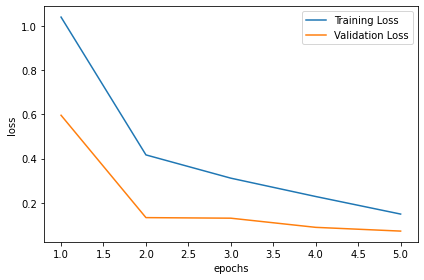

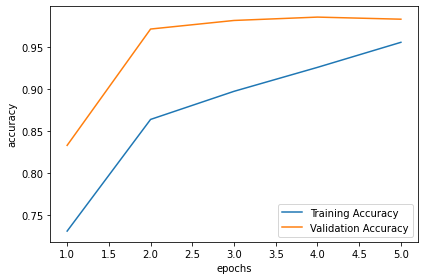

In [43]:
show_hist('Train_loss', 'Valid_loss', 'Training Loss', 'Validation Loss', 'loss')
show_hist('Train_Accuracy', 'Valid_Accuracy', 'Training Accuracy', 'Validation Accuracy', 'accuracy')